In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from tqdm import tqdm

In [2]:
def calculate_mu_sigma(log_mean, log_std):
    mu = np.log(log_mean**2 / np.sqrt(log_std**2 + log_mean**2))
    sigma = np.sqrt(np.log(1 + (log_std**2 / log_mean**2)))
    return mu, sigma

In [3]:
MEAN_OPTIMAL_LIMIT = 100_000
SIGMA_OPTIMAL_LIMIT = 100_000
LOG_MEAN_OPTIMAL_LIMIT, LOG_SIGMA_OPTIMAL_LIMIT = calculate_mu_sigma(MEAN_OPTIMAL_LIMIT, SIGMA_OPTIMAL_LIMIT)

MEAN_MAX_VALUE = 10_000
SIGMA_MAX_VALUE = 10_000
LOG_MEAN_MAX_VALUE, LOG_SIGMA_MAX_VALUE = calculate_mu_sigma(MEAN_MAX_VALUE, SIGMA_MAX_VALUE)

MEAN_INCOME = 100_000
SIGMA_INCOME = 100_000
LOG_MEAN_INCOME, LOG_SIGMA_INCOME = calculate_mu_sigma(MEAN_INCOME, SIGMA_INCOME)

MEAN_SCALE = (MEAN_OPTIMAL_LIMIT)**(-2)*10000
SIGMA_SCALE = MEAN_SCALE/3


MIN_CREDIT_LIMIT = 100
MAX_CREDIT_LIMIT = 1_000_000

CREDIT_CARD_PAYMENT = 0.05

PDN50_80 = 0.2
PDN80 = 0.05


In [4]:
MEAN_SCALE, SIGMA_SCALE

(1e-06, 3.333333333333333e-07)

In [5]:
LOG_MEAN_MAX_VALUE, LOG_SIGMA_MAX_VALUE

(8.86376678169621, 0.8325546111576977)

In [6]:
class CreditCardClient:
    def __init__(self, income: float, credit_payments: float, value_func):
        self.income = income
        self.credit_payments = credit_payments

        self.value_func = value_func
        self.opt_lim = 0
        self.opt_val = 0
        self.min_pos_value = 100

        self.optimal_limit = {}
        self.optimal_value = {}

    def credit_card_value(self, x):
        return self.value_func(x) if x > 0 else 0
    
    def pdn(self, new_limit=0):
        a = self.credit_payments + credit_card_payment(new_limit)
        b = self.income
        return 1.0*a/b

def generate_objects(n, pdn = [0, 0.9]):
    objects = []
    for k in range(n):
            np.random.seed(k)
            a = random.normalvariate(MEAN_SCALE, SIGMA_SCALE)
            if (a < 0):
                a *= -1
            b = random.lognormvariate(LOG_MEAN_OPTIMAL_LIMIT, LOG_SIGMA_OPTIMAL_LIMIT)
            c = random.lognormvariate(LOG_MEAN_MAX_VALUE, LOG_SIGMA_MAX_VALUE)
            
            def func(x, a=a, b=b, c=c):
                return -1*a*(x-b)**2 + c
            
            client_income = random.lognormvariate(LOG_MEAN_INCOME, LOG_SIGMA_INCOME)
            client_credit_pament = random.uniform(pdn[0], pdn[1]) * client_income
            obj = CreditCardClient(income=client_income, credit_payments=client_credit_pament, value_func=func)

            obj.opt_lim = b
            obj.opt_val = c
            obj.min_pos_value = max(int(b - (abs(c/a))**0.5), 100)

            objects.append(obj)
    return objects

def credit_card_payment(credit_card_limit):
    return credit_card_limit*CREDIT_CARD_PAYMENT


In [7]:
random.seed(42)
credit_card_clients = generate_objects(10_000)

In [8]:
def plot_incomes(credit_card_clients):
    incomes = []
    for x in credit_card_clients:
        incomes.append(x.income)

    plt.figure(figsize=(8, 6))
    plt.hist(incomes, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Распределение доходов")
    plt.xlim((0, 1_000_000))
    plt.xlabel("Доход")
    plt.ylabel("Количество")
    plt.grid(True)
    plt.show()

def plot_pdn(credit_card_clients, strategy=None):
    pdns = []
    if strategy is None:
        for x in credit_card_clients:
            pdns.append(x.pdn())
    else:
        for x in credit_card_clients:
            pdns.append(x.pdn(x.optimal_limit[strategy]))

    plt.figure(figsize=(8, 6))
    plt.hist(pdns, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Распределение ПДН")
    plt.xlim((0, 2))
    plt.xlabel("ПДН")
    plt.ylabel("Количество")
    plt.grid(True)
    plt.show()

def plot_value_func(credit_card_clients):
    x = np.linspace(0, 200_000, 100)
    plt.figure(figsize=(8, 6))
    value = np.zeros(len(x))
    for client in credit_card_clients:
        y = [client.credit_card_value(xi) for xi in x]
        value += np.array(y)
    value = value / len(credit_card_clients)
    plt.plot(x, y, alpha=1, color='blue') 

    plt.title("Зависимость функций прибыльности от КЛ")
    plt.xlabel("КЛ")
    plt.ylabel("Прибыльность")
    plt.ylim((-20_000, 30_000))
    plt.grid(True)
    plt.show()




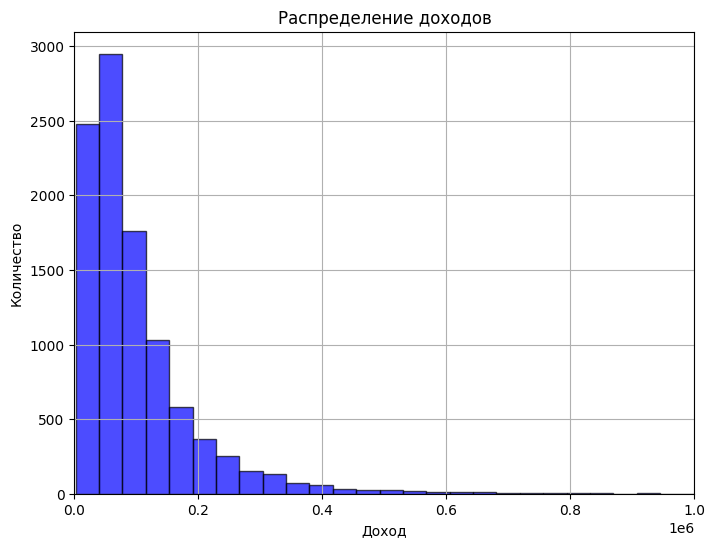

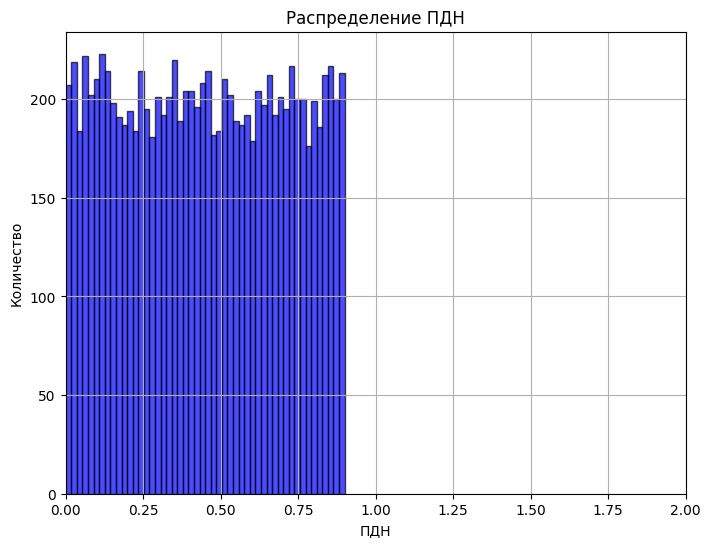

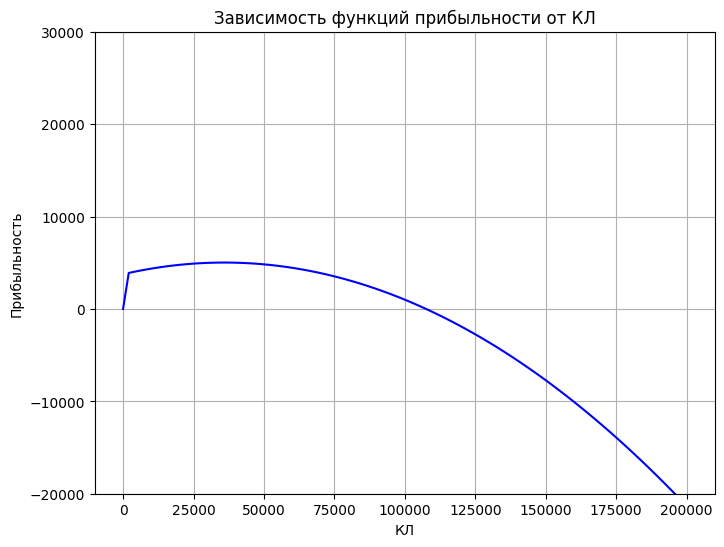

In [9]:
plot_incomes(credit_card_clients)
plot_pdn(credit_card_clients)
plot_value_func(credit_card_clients)

In [10]:
def stratagies_comparassions(clients, stratagies):
    result = pd.DataFrame(columns=['стратегия', 'колво КК', 'суммарная прибыль, m', 'средний лимит', 'норматив 50-80', 'норматив 80+', 'есть нарушения'])
    for s in stratagies:
        s1 = 0
        s2 = 0
        s3 = 0
        approve_credit_cards = 0
        total_value = 0
        total_limits = 0
        for client in clients:
            if (client.optimal_limit[s] != 0):
                approve_credit_cards += 1
                total_value += client.optimal_value[s]
                total_limits += client.optimal_limit[s]

                pdn = client.pdn(client.optimal_limit[s])
                if pdn <= 0.5:
                    s1 += client.optimal_limit[s]
                elif pdn <= 0.8:
                    s2 += client.optimal_limit[s]
                else:
                    s3 += client.optimal_limit[s]
            else:
                continue
        result.loc[len(result)] = [s, approve_credit_cards, round(total_value/1000000, 2), int(total_limits/approve_credit_cards), round(1.0*s2/(s1 + s2 + s3) * 100, 1), round(1.0*s3/(s1 + s2 + s3) * 100, 1), (1.0*s2/(s1 + s2 + s3) > PDN50_80) or (1.0*s3/(s1 + s2 + s3) > PDN80)]

    return result

In [11]:
min_lim_step = 100

def bin_search(clients, tag, l, r, target_value, pdn_l, pdn_r, eps, type='abs'):
    while ((r-l) > eps):
        m = (l + r)/2.0
        s = 0
        for client in clients:
            pdn = client.pdn(client.optimal_limit[tag])
            if type == 'abs':
                value = client.optimal_value[tag]
            elif type == 'eps':
                value = client.optimal_value[tag]/(0.001 + client.optimal_limit[tag])
            if (value > m and pdn > pdn_l and pdn <= pdn_r):
                s += client.optimal_limit[tag]
        if (s > target_value):
            l = m
        elif (s < target_value):
            r = m
        else:
            l = r
            break
    return r


def limit_finder(client, l, r, target, bin=True):
    r = min(r, MAX_CREDIT_LIMIT)
    l = max(l, MIN_CREDIT_LIMIT)
    _l = l
    _r = r


    # оптимизация для унимодальных функций
    if bin and target >= 0:
        _r = min(_r, client.opt_lim)

    opt_lim = 0  

    if (r < l):
        return 0
    
    for lim in range(int(_l), int(_r), min_lim_step):
        value = client.credit_card_value(lim)/lim
        if value > target:
            opt_lim = lim
            break
    if (opt_lim == 0):
        return 0

    
    _l = opt_lim
    _r = r
    
    for lim in range(int(_l), int(_r), min_lim_step):
        value = (client.credit_card_value(lim + min_lim_step) - client.credit_card_value(lim))/min_lim_step
        if value > target:
            opt_lim = lim
        else:
            break
    if (opt_lim < l or opt_lim > r):
        print('error')
    return opt_lim

In [12]:
def without_regulation_stratagy(clients, tag = 'No restriction'):
    for client in clients:
        client.optimal_limit[tag] = client.opt_lim
        client.optimal_value[tag] = client.opt_val
    return [tag, None,None,None]
    
def greedy_stratagy(clients, tag = 'GREEDY', _cut_off_50_80 = None, _cut_off_80 = None):
    # optimal limits
    for client in clients:
        client.optimal_limit[tag] = client.opt_lim
        client.optimal_value[tag] = client.opt_val
    # approving 50-
    s1 = 0
    for client in clients:
        if (client.pdn(client.optimal_limit[tag]) <= 0.5):
            s1 += client.optimal_limit[tag]
            continue

    # calculating max budget for 50-80 and 80+   
    max_s2 = s1 / (1 - PDN50_80 - PDN80) * PDN50_80 * 0.99
    max_s3 = s1 / (1 - PDN50_80 - PDN80) * PDN80 * 0.99

    # calculating cutoff for 50-80   
    if (_cut_off_50_80 is not None):
        cut_off_50_80 = _cut_off_50_80
    else:
        cut_off_50_80 = bin_search(clients, tag, 0, MEAN_MAX_VALUE*3, max_s2, 0.5, 0.8, MEAN_MAX_VALUE/1000)


    # calculating cutoff for 80+        
    if (_cut_off_80 is not None):
        cut_off_80 = _cut_off_80
    else:
        cut_off_80 = bin_search(clients, tag, 0, MEAN_MAX_VALUE*3, max_s3, 0.8, 1_000_000, MEAN_MAX_VALUE/1000)


    print(tag, f"cutoff 50-80 {cut_off_50_80:.0f}, cutoff 80 {cut_off_80:.0f}")

    # removing limits where it is not valuable enough
    for client in clients:
        pdn = client.pdn(client.optimal_limit[tag])
        if (pdn > 0.5 and pdn <= 0.8):
            if (client.optimal_value[tag] <= cut_off_50_80):
                client.optimal_value[tag] = 0
                client.optimal_limit[tag] = 0
        elif (pdn > 0.8):
            if (client.optimal_value[tag] <= cut_off_80):
                client.optimal_value[tag] = 0
                client.optimal_limit[tag] = 0
    
    return [tag, None,cut_off_50_80,cut_off_80]

def integral_value(clients, tag = 'integral value', _cut_off_50_80 = None, _cut_off_80 = None):
    # optimal limits
    for client in clients:
        client.optimal_limit[tag] = client.opt_lim
        client.optimal_value[tag] = client.opt_val

    # approving 50-
    s1 = 0
    for client in clients:
        if (client.pdn(client.optimal_limit[tag]) <= 0.5):
            s1 += client.optimal_limit[tag]

    # calculating max budget for 50-80 and 80+   
    max_s2 = s1 / (1 - PDN50_80 - PDN80) * PDN50_80 * 0.99
    max_s3 = s1 / (1 - PDN50_80 - PDN80) * PDN80 * 0.99

    # calculating cutoff for 50-80  
    if (_cut_off_50_80 is not None):
        cut_off_50_80 = _cut_off_50_80
    else:
        cut_off_50_80 = bin_search(clients, tag, 0, 3*MEAN_MAX_VALUE/MEAN_OPTIMAL_LIMIT, max_s2, 0.5, 0.8, MEAN_MAX_VALUE/MEAN_OPTIMAL_LIMIT/1000.0, type='eps')


    # calculating cutoff for 80+        
    if (_cut_off_80 is not None):
        cut_off_80 = _cut_off_80
    else:
        cut_off_80 = bin_search(clients, tag, 0, 3*MEAN_MAX_VALUE/MEAN_OPTIMAL_LIMIT, max_s3, 0.8, 1_000_000, MEAN_MAX_VALUE/MEAN_OPTIMAL_LIMIT/1000.0, type='eps')
    
    
    print(tag, f"cutoff 50-80 {cut_off_50_80:.3f}, cutoff 80 {cut_off_80:.3f}")

    # removing limits where it is not valuable enough
    for client in clients:
        pdn = client.pdn(client.optimal_limit[tag])
        if (pdn > 0.5 and pdn <= 0.8):
            if (client.optimal_value[tag]/(client.optimal_limit[tag]+0.001) <= cut_off_50_80):
                client.optimal_value[tag] = 0
                client.optimal_limit[tag] = 0
        elif (pdn > 0.8):
            if (client.optimal_value[tag]/(client.optimal_limit[tag]+0.001) <= cut_off_80):
                client.optimal_value[tag] = 0
                client.optimal_limit[tag] = 0
    
    return [tag, None,cut_off_50_80,cut_off_80]
        
    

def differential_value(clients, tag = 'differential value', cut_off = [None, None, None], bin=True):
       # optimal limits
    for client in clients:
        client.optimal_limit[tag] = client.opt_lim
        client.optimal_value[tag] = client.opt_val
        
    # approving 50-
    s1 = 0
    for client in clients:
        if (client.pdn(client.optimal_limit[tag]) <= 0.5):
            s1 += client.optimal_limit[tag]
            continue
    
    print(tag, f"cutoff 50-80 {cut_off[1]:.3f}, cutoff 80 {cut_off[2]:.3f}")

    # removing limits where it is not valuable enough
    for client in clients:
        pdn = client.pdn(client.optimal_limit[tag])
        if (pdn > 0.5 and pdn <= 0.8):
            opt_lim = limit_finder(client, client.min_pos_value, int(client.optimal_limit[tag]), cut_off[1], bin=bin)
            client.optimal_value[tag] = client.credit_card_value(opt_lim)
            client.optimal_limit[tag] = opt_lim 
        elif (pdn > 0.8):
            opt_lim = limit_finder(client, client.min_pos_value, int(client.optimal_limit[tag]), cut_off[2], bin=bin)
            client.optimal_value[tag] = client.credit_card_value(opt_lim)
            client.optimal_limit[tag] = opt_lim 
    
    
    return [tag, None,cut_off[1],cut_off[2]]


def differential_value_neg(clients, tag = 'diff value neg + pdn', cut_off = [None, None, None], bin=True):
        # optimal limits
    for client in clients:
        client.optimal_limit[tag] = client.opt_lim
        client.optimal_value[tag] = client.opt_val
    
    print(tag, f"cutoff 0-50 {cut_off[0]:.3f}, cutoff 50-80 {cut_off[1]:.3f}, cutoff 80 {cut_off[2]:.3f}")

    # removing limits where it is not valuable enough
    for client in clients:
        pdn = client.pdn(client.optimal_limit[tag])
        lim_max_50 = (0.5 - client.pdn())*client.income/CREDIT_CARD_PAYMENT
        if (pdn <= 0.5):
            #opt_lim = limit_finder(client, MIN_CREDIT_LIMIT, MAX_CREDIT_LIMIT, cut_off[0])
            opt_lim = limit_finder(client, MIN_CREDIT_LIMIT, lim_max_50, cut_off[0], bin=bin)
            client.optimal_value[tag] = client.credit_card_value(opt_lim) 
            client.optimal_limit[tag] = opt_lim 
            #print(lim_max_50, opt_lim, client.opt_lim)
        elif (pdn > 0.5 and pdn <= 0.8):
            opt_lim = limit_finder(client, MIN_CREDIT_LIMIT, MAX_CREDIT_LIMIT, cut_off[1], bin=bin)
            client.optimal_value[tag] = client.credit_card_value(opt_lim) 
            client.optimal_limit[tag] = opt_lim 
        elif (pdn > 0.8):
            opt_lim = limit_finder(client, MIN_CREDIT_LIMIT, MAX_CREDIT_LIMIT, cut_off[2], bin=bin)
            client.optimal_value[tag] = client.credit_card_value(opt_lim)
            client.optimal_limit[tag] = opt_lim 

    
    return [tag, cut_off[0],cut_off[1],cut_off[2]]

def differential_value_plus(clients, tag = 'differential value plus', cut_off = [None, None, None], bin=True):

    print(tag, f"cutoff 0-50 {cut_off[0]:.3f}, cutoff 50-80 {cut_off[1]:.3f}, cutoff 80 {cut_off[2]:.3f}")

    # removing limits where it is not valuable enough
    for client in clients:
        lim_max_50 = (0.5 - client.pdn())*client.income/CREDIT_CARD_PAYMENT
        lim_max_80 = (0.8 - client.pdn())*client.income/CREDIT_CARD_PAYMENT
        
        lim = [0, 0, 0]
        value = [0, 0, 0]
        delta_value = [0, 0, 0]

        lim[0] = limit_finder(client, MIN_CREDIT_LIMIT, int(lim_max_50), cut_off[0], bin=bin) 
        lim[1] = limit_finder(client, max(int(lim_max_50), MIN_CREDIT_LIMIT), int(lim_max_80), cut_off[1], bin=bin) 
        lim[2] = limit_finder(client, max(int(lim_max_80), MIN_CREDIT_LIMIT), MAX_CREDIT_LIMIT, cut_off[2], bin=bin) 


        value[0] = client.credit_card_value(lim[0])
        value[1] = client.credit_card_value(lim[1])
        value[2] = client.credit_card_value(lim[2])

        # 0->50
        delta_value[0] = (value[1]) - (value[0]) + lim[0]*cut_off[0] - lim[1]*cut_off[1]
        # 50->80
        delta_value[1] = (value[2]) - (value[1]) + lim[1]*cut_off[1] - lim[2]*cut_off[2]
        # 0->80
        delta_value[2] = (value[2]) - (value[0]) + lim[0]*cut_off[0] - lim[2]*cut_off[2]

        if (delta_value[0] >= 0 and delta_value[1] >= 0):
            client.optimal_limit[tag] = lim[2]
        elif (delta_value[0] >= 0 and delta_value[1] <= 0):
            client.optimal_limit[tag] = lim[1]
        elif (delta_value[0] <= 0 and delta_value[1] <= 0):
            client.optimal_limit[tag] = lim[0]
        elif (delta_value[0] <= 0 and delta_value[1] >= 0):
            if (delta_value[2] >= 0):
                client.optimal_limit[tag] = lim[2]
            else:
                client.optimal_limit[tag] = lim[0]
        else:
            print('error')
        
        client.optimal_value[tag] = client.credit_card_value(client.optimal_limit[tag])
    
    return [tag, cut_off[0],cut_off[1],cut_off[2]]

        

In [13]:

cut_off_diff = [None, 0.052, 0.0935]

cut_off_diff_neg = [-0.01385, 0.0473, 0.0881]
print(cut_off_diff_neg[1] * 0.2 + cut_off_diff_neg[2]*0.05)


cut_off_diff_plus = [-0.012, 0.0429, 0.0765]
print(cut_off_diff_plus[1] * 0.2 + cut_off_diff_plus[2]*0.05)

0.013865000000000002
0.012405000000000001


In [14]:
strategies = pd.DataFrame(columns=['стратегия', 'cutoff 0-50', 'cutoff 50-80','cutoff 80+'])

In [15]:
strategies.loc[len(strategies)] = without_regulation_stratagy(credit_card_clients, tag='Алгоритм в отсутствие ограничений')
strategies.loc[len(strategies)] = greedy_stratagy(credit_card_clients, tag='Жадный алгоритм')
strategies.loc[len(strategies)] = integral_value(credit_card_clients, tag='Максимизация удельной прибыли')
strategies.loc[len(strategies)] = differential_value(credit_card_clients, cut_off=cut_off_diff, tag='Дифференциальная максимизация удельной прибыльности')
strategies.loc[len(strategies)] = differential_value_neg(credit_card_clients, cut_off=cut_off_diff_neg, tag='Дифференциальная максимизация удельной прибыльности: раздувание 0-50')
strategies.loc[len(strategies)] = differential_value_plus(credit_card_clients, cut_off=cut_off_diff_plus, tag='Дифференциальная максимизация удельной прибыльности: общий случай')

Жадный алгоритм cutoff 50-80 10173, cutoff 80 22771
Максимизация удельной прибыли cutoff 50-80 0.092, cutoff 80 0.185
Дифференциальная максимизация удельной прибыльности cutoff 50-80 0.052, cutoff 80 0.093


C:\Users\ismag\AppData\Local\Temp\ipykernel_17612\4262211017.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  strategies.loc[len(strategies)] = greedy_stratagy(credit_card_clients, tag='Жадный алгоритм')


Дифференциальная максимизация удельной прибыльности: раздувание 0-50 cutoff 0-50 -0.014, cutoff 50-80 0.047, cutoff 80 0.088


C:\Users\ismag\AppData\Local\Temp\ipykernel_17612\4262211017.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  strategies.loc[len(strategies)] = differential_value_neg(credit_card_clients, cut_off=cut_off_diff_neg, tag='Дифференциальная максимизация удельной прибыльности: раздувание 0-50')


Дифференциальная максимизация удельной прибыльности: общий случай cutoff 0-50 -0.012, cutoff 50-80 0.043, cutoff 80 0.076


In [16]:
df = stratagies_comparassions(credit_card_clients, credit_card_clients[0].optimal_limit.keys())
df

,стратегия,колво КК,"суммарная прибыль, m",средний лимит,норматив 50-80,норматив 80+,есть нарушения
0,Алгоритм в отсутствие ограничений,10000,100.49,101174,31.1,30.7,True
1,Жадный алгоритм,5852,73.51,87918,19.8,5.0,False
2,Максимизация удельной прибыли,6823,79.66,75417,19.8,5.0,False
3,Дифференциальная максимизация удельной прибыль...,8219,87.19,64121,19.9,4.9,False
4,Дифференциальная максимизация удельной прибыль...,8287,87.73,69647,20.0,5.0,False
5,Дифференциальная максимизация удельной прибыль...,8611,89.56,72235,20.0,5.0,False


In [ ]:
df.to_excel('result.xlsx')
strategies.to_excel('strategies.xlsx')

In [20]:
random.seed(42)
sub_clients1 = generate_objects(5_000, pdn=[0, 0.85])
sub_clients2 = generate_objects(5_000, pdn=[0, 0.95])

In [21]:

cut_off_diff = [None, 0.0525, 0.075]

cut_off_diff_neg = [-0.013, 0.0495, 0.072]
print(cut_off_diff_neg[1] * 0.2 + cut_off_diff_neg[2]*0.05)


cut_off_diff_plus = [-0.01, 0.0428, 0.062]
print(cut_off_diff_plus[1] * 0.2 + cut_off_diff_plus[2]*0.05)

0.013500000000000002
0.01166


In [22]:
without_regulation_stratagy(sub_clients1, tag='No restricitons sub')
greedy_stratagy(sub_clients1, tag='greedy sub')
integral_value(sub_clients1, tag='integral sub')
differential_value(sub_clients1, cut_off=cut_off_diff, tag='diff sub')
differential_value_neg(sub_clients1, cut_off=cut_off_diff_neg, tag='diff neg sub')
differential_value_plus(sub_clients1, cut_off=cut_off_diff_plus, tag='diff plus sub')
df = stratagies_comparassions(sub_clients1, sub_clients1[0].optimal_limit.keys())
df

greedy sub cutoff 50-80 10042, cutoff 80 20098
integral sub cutoff 50-80 0.089, cutoff 80 0.144
diff sub cutoff 50-80 0.052, cutoff 80 0.075
diff neg sub cutoff 0-50 -0.013, cutoff 50-80 0.050, cutoff 80 0.072
diff plus sub cutoff 0-50 -0.010, cutoff 50-80 0.043, cutoff 80 0.062


,стратегия,колво КК,"суммарная прибыль, m",средний лимит,норматив 50-80,норматив 80+,есть нарушения
0,No restricitons sub,5000,50.02,99881,33.3,25.4,True
1,greedy sub,3098,38.39,88514,19.8,4.9,False
2,integral sub,3604,41.51,76060,19.8,5.0,False
3,diff sub,4177,44.37,66920,19.9,5.0,False
4,diff neg sub,4206,44.57,72154,19.9,4.9,False
5,diff plus sub,4386,45.52,74419,20.0,4.9,False


In [23]:

cut_off_diff = [None, 0.0528, 0.11]

cut_off_diff_neg = [-0.0146, 0.0485, 0.105]
print(cut_off_diff_neg[1] * 0.2 + cut_off_diff_neg[2]*0.05)


cut_off_diff_plus = [-0.0133, 0.0457, 0.0914]
print(cut_off_diff_plus[1] * 0.2 + cut_off_diff_plus[2]*0.05)

0.014950000000000001
0.01371


In [24]:
without_regulation_stratagy(sub_clients2, tag='No restricitons sub')
greedy_stratagy(sub_clients2, tag='greedy sub')
integral_value(sub_clients2, tag='integral sub')
differential_value(sub_clients2, cut_off=cut_off_diff, tag='diff sub')
differential_value_neg(sub_clients2, cut_off=cut_off_diff_neg, tag='diff neg sub')
differential_value_plus(sub_clients2, cut_off=cut_off_diff_plus, tag='diff plus sub')
df = stratagies_comparassions(sub_clients2, sub_clients2[0].optimal_limit.keys())
df

greedy sub cutoff 50-80 9880, cutoff 80 26477
integral sub cutoff 50-80 0.092, cutoff 80 0.218
diff sub cutoff 50-80 0.053, cutoff 80 0.110
diff neg sub cutoff 0-50 -0.015, cutoff 50-80 0.049, cutoff 80 0.105
diff plus sub cutoff 0-50 -0.013, cutoff 50-80 0.046, cutoff 80 0.091


,стратегия,колво КК,"суммарная прибыль, m",средний лимит,норматив 50-80,норматив 80+,есть нарушения
0,No restricitons sub,5000,50.47,102466,28.6,35.8,True
1,greedy sub,2753,34.82,87911,19.8,4.9,False
2,integral sub,3215,38.04,75313,19.8,5.0,False
3,diff sub,4055,42.71,60946,19.9,4.9,False
4,diff neg sub,4089,43.00,66518,20.0,4.9,False
5,diff plus sub,4233,43.99,69523,19.9,5.0,False


In [25]:
sub_clients = sub_clients1 + sub_clients2

In [26]:

cut_off_diff = [None, 0.0526, 0.0933]

cut_off_diff_neg = [-0.014, 0.0485, 0.088]
print(cut_off_diff_neg[1] * 0.2 + cut_off_diff_neg[2]*0.05)


cut_off_diff_plus = [-0.012, 0.044, 0.0775]
print(cut_off_diff_plus[1] * 0.2 + cut_off_diff_plus[2]*0.05)

0.014100000000000001
0.012675


In [27]:
strats = ['No restricitons tot','greedy tot', 'integral tot','diff tot', 'diff neg tot','diff plus tot']

In [28]:
without_regulation_stratagy(sub_clients, tag='No restricitons tot')
greedy_stratagy(sub_clients, tag='greedy tot')
integral_value(sub_clients, tag='integral tot')
differential_value(sub_clients, cut_off=cut_off_diff, tag='diff tot')
differential_value_neg(sub_clients, cut_off=cut_off_diff_neg, tag='diff neg tot')
differential_value_plus(sub_clients, cut_off=cut_off_diff_plus, tag='diff plus tot')
df = stratagies_comparassions(sub_clients, strats)
df

greedy tot cutoff 50-80 9998, cutoff 80 22522
integral tot cutoff 50-80 0.089, cutoff 80 0.187
diff tot cutoff 50-80 0.053, cutoff 80 0.093
diff neg tot cutoff 0-50 -0.014, cutoff 50-80 0.049, cutoff 80 0.088
diff plus tot cutoff 0-50 -0.012, cutoff 50-80 0.044, cutoff 80 0.077


,стратегия,колво КК,"суммарная прибыль, m",средний лимит,норматив 50-80,норматив 80+,есть нарушения
0,No restricitons tot,10000,100.49,101174,30.9,30.7,True
1,greedy tot,5862,73.58,88056,19.8,4.9,False
2,integral tot,6830,79.77,75624,19.8,5.0,False
3,diff tot,8239,87.23,64026,20.0,5.0,False
4,diff neg tot,8300,87.73,69577,19.9,5.0,False
5,diff plus tot,8622,89.60,72145,20.0,4.9,False


In [29]:
df = stratagies_comparassions(sub_clients, sub_clients[0].optimal_limit.keys())
df

,стратегия,колво КК,"суммарная прибыль, m",средний лимит,норматив 50-80,норматив 80+,есть нарушения
0,No restricitons sub,10000,100.49,101174,30.9,30.7,True
1,greedy sub,5851,73.22,88230,19.8,4.9,False
2,integral sub,6819,79.55,75708,19.8,5.0,False
3,diff sub,8232,87.08,63977,19.9,4.9,False
4,diff neg sub,8295,87.57,69376,19.9,4.9,False
5,diff plus sub,8619,89.51,72014,19.9,5.0,False
6,No restricitons tot,10000,100.49,101174,30.9,30.7,True
7,greedy tot,5862,73.58,88056,19.8,4.9,False
8,integral tot,6830,79.77,75624,19.8,5.0,False
9,diff tot,8239,87.23,64026,20.0,5.0,False


In [30]:
df.to_excel('optimal.xlsx')